<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D1_CNN1_A3_FT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import keras
import os
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Data Preparation

In [ ]:
 #Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/My Drive/Dataset/Dataset2/combined_dataset/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [ ]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path =  "/content/drive/My Drive/Dataset/Dataset2/combined_dataset/combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [ ]:
import pandas as pd
train_aug_df = pd.read_csv( "/content/drive/My Drive/Dataset/Dataset2/combined_dataset/images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("/content/drive/My Drive/Dataset/Dataset2/combined_dataset/images_filenames_labels_test.csv")


In [ ]:
train_aug_df.head()

,filename,age
0,/content/content/combined_faces_train_augmente...,43
1,/content/content/combined_faces_train_augmente...,71
2,/content/content/combined_faces_train_augmente...,6
3,/content/content/combined_faces_train_augmente...,18
4,/content/content/combined_faces_train_augmente...,25


In [ ]:
test_df.head()

,filename,age
0,/content/content/combined_faces/8_163.jpg,8
1,/content/content/combined_faces/38_66.jpg,38
2,/content/content/combined_faces/40_177.jpg,40
3,/content/content/combined_faces/36_267.jpg,36
4,/content/content/combined_faces/8_349.jpg,8


In [ ]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

In [ ]:
def categorize_age(age):
    for range_name, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return range_name
    return None

In [ ]:
train_aug_df['target'] = train_aug_df['age'].map(categorize_age)
test_df['target'] = test_df['age'].map(categorize_age)

In [ ]:
train_aug_df.head()

,filename,age,target
0,/content/content/combined_faces_train_augmente...,43,4
1,/content/content/combined_faces_train_augmente...,71,6
2,/content/content/combined_faces_train_augmente...,6,1
3,/content/content/combined_faces_train_augmente...,18,2
4,/content/content/combined_faces_train_augmente...,25,3


In [ ]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,4
2,/content/content/combined_faces/40_177.jpg,40,4
3,/content/content/combined_faces/36_267.jpg,36,4
4,/content/content/combined_faces/8_349.jpg,8,1


In [ ]:
train_aug_df.shape

(234400, 3)

In [ ]:
test_df.shape

(10046, 3)

In [ ]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    image_resized = tf.image.resize(image_decoded, [224, 224])
    label = tf.one_hot(label, num_classes)

    return image_resized, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # CONV1
x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)  # POOL1

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # CONV2
x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)  # POOL2

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # CONV3
x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)  # POOL3

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # CONV4
x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)  # POOL4

x = GlobalAveragePooling2D()(x)

x = Dense(132, activation='relu')(x)
predictions = Dense(len(age_ranges), activation='softmax')(x)


# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_FineTuned3.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)

In [ ]:
# Train your model
history = model.fit(train_aug_dataset, validation_data=test_dataset, epochs=60,batch_size=512, callbacks=[early_stopping,model_checkpoint])

Epoch 1/60
458/458 [==============================] - ETA: 0s - loss: 1.1281 - accuracy: 0.5281
Epoch 1: val_accuracy improved from -inf to 0.53235, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_FineTuned3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


458/458 [==============================] - 120s 233ms/step - loss: 1.1281 - accuracy: 0.5281 - val_loss: 1.0873 - val_accuracy: 0.5324
Epoch 2/60
458/458 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.6105
Epoch 2: val_accuracy improved from 0.53235 to 0.56540, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_FineTuned3.h5
458/458 [==============================] - 95s 207ms/step - loss: 0.9237 - accuracy: 0.6105 - val_loss: 1.0296 - val_accuracy: 0.5654
Epoch 3/60
458/458 [==============================] - ETA: 0s - loss: 0.8682 - accuracy: 0.6333
Epoch 3: val_accuracy improved from 0.56540 to 0.57486, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_FineTuned3.h5
458/458 [==============================] - 95s 207ms/step - loss: 0.8682 - accuracy: 0.6333 - val_loss: 1.0127 - val_accuracy: 0.5749
Epoch 4/60
458/458 [==============================] - ETA: 0s - loss: 0.8270 - accuracy: 0.6516
Epoch 4

In [ ]:
# Save the training history
history_dict = history.history

# Plot the training and validation metrics
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

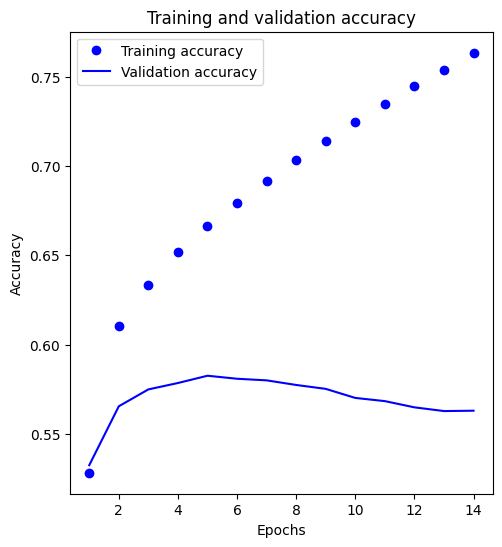

In [ ]:
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

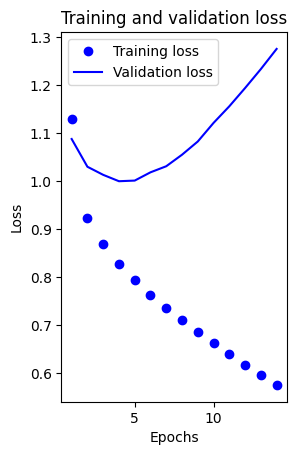

In [ ]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_FineTuned3.h5')
# Evaluate the model
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(test_dataset, verbose=1)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


20/20 [==============================] - 5s 241ms/step - loss: 1.0008 - accuracy: 0.5825
Validation Loss: 1.0007582902908325
Validation Accuracy: 0.5825204253196716


In [ ]:
representative_ages = [np.mean(rng) for rng in age_ranges]

In [ ]:
# Convert predictions and true labels back to representative ages
y_pred = model.predict(test_dataset)
y_pred_ages = [representative_ages[np.argmax(pred)] for pred in y_pred]

# Since val_labels is one-hot encoded, convert it to a numpy array and then to representative ages
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_ages = [representative_ages[np.argmax(true)] for true in val_labels_np]

# Calculate MAE
mae = np.mean(np.abs(np.array(y_true_ages) - np.array(y_pred_ages)))
print(f'Test MAE: {mae:.2f}')

20/20 [==============================] - 6s 240ms/step
Test MAE: 7.85


In [ ]:
# Calculate MAE for each age range
age_range_mae = {}
for idx, age_range in enumerate(age_ranges):
    # Get the indices for the current age range
    range_indices = [i for i, age in enumerate(y_true_ages) if age_range[0] <= age <= age_range[1]]

    if range_indices:
        # Calculate MAE for the current age range
        y_true_range = np.array([y_true_ages[i] for i in range_indices])
        y_pred_range = np.array([y_pred_ages[i] for i in range_indices])

        mae = np.mean(np.abs(y_true_range - y_pred_range))
        age_range_mae[age_range] = mae

# Print MAE for each age range
for age_range, mae in age_range_mae.items():
    print(f"Age Range {age_range}: MAE = {mae:.2f}")

Age Range (1, 2): MAE = 2.14
Age Range (3, 9): MAE = 8.15
Age Range (10, 20): MAE = 7.85
Age Range (21, 27): MAE = 7.88
Age Range (28, 45): MAE = 6.92
Age Range (46, 65): MAE = 12.09
Age Range (66, 116): MAE = 8.69


In [ ]:
# Make predictions on the validation dataset
predictions = model.predict(test_dataset)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since val_labels is one-hot encoded, convert it to class labels
# Note: val_labels_np should be a concatenation of one-hot encoded labels from val_dataset
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)  # Flatten the labels
true_classes = np.argmax(val_labels_np, axis=1)

# Optionally, print some of the predicted and true class labels to verify
print("Sample predicted classes:", predicted_classes[:10])
print("Sample true classes:", true_classes[:10])

20/20 [==============================] - 5s 240ms/step
Sample predicted classes: [2 4 4 4 1 4 4 6 1 6]
Sample true classes: [1 4 4 4 1 4 4 6 1 6]


In [ ]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.58
Precision: 0.59
Recall: 0.58
F1-score: 0.58


In [ ]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

In [ ]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-2: 0.81
Accuracy for age range 3-9: 0.43
Accuracy for age range 10-20: 0.53
Accuracy for age range 21-27: 0.45
Accuracy for age range 28-45: 0.62
Accuracy for age range 46-65: 0.56
Accuracy for age range 66-116: 0.78


In [ ]:
# Example metrics calculation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Detailed classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=[f'{start}-{end}' for start, end in age_ranges]))

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

         1-2       0.92      0.81      0.86       958
         3-9       0.64      0.43      0.51       845
       10-20       0.49      0.53      0.51       941
       21-27       0.56      0.45      0.49      2007
       28-45       0.53      0.62      0.57      2807
       46-65       0.56      0.56      0.56      1679
      66-116       0.61      0.78      0.68       809

    accuracy                           0.58     10046
   macro avg       0.61      0.60      0.60     10046
weighted avg       0.59      0.58      0.58     10046


Confusion Matrix:
[[ 776  134   17   13    8    7    3]
 [  60  362  288   65   45   18    7]
 [   2   37  500  161  220   21    0]
 [   0   16  131  895  873   77   15]
 [   3   15   61  453 1743  482   50]
 [   1    2   18   22  358  942  336]
 [   2    2    4    1   22  144  634]]


20/20 [==============================] - 5s 241ms/step
Normalized confusion matrix


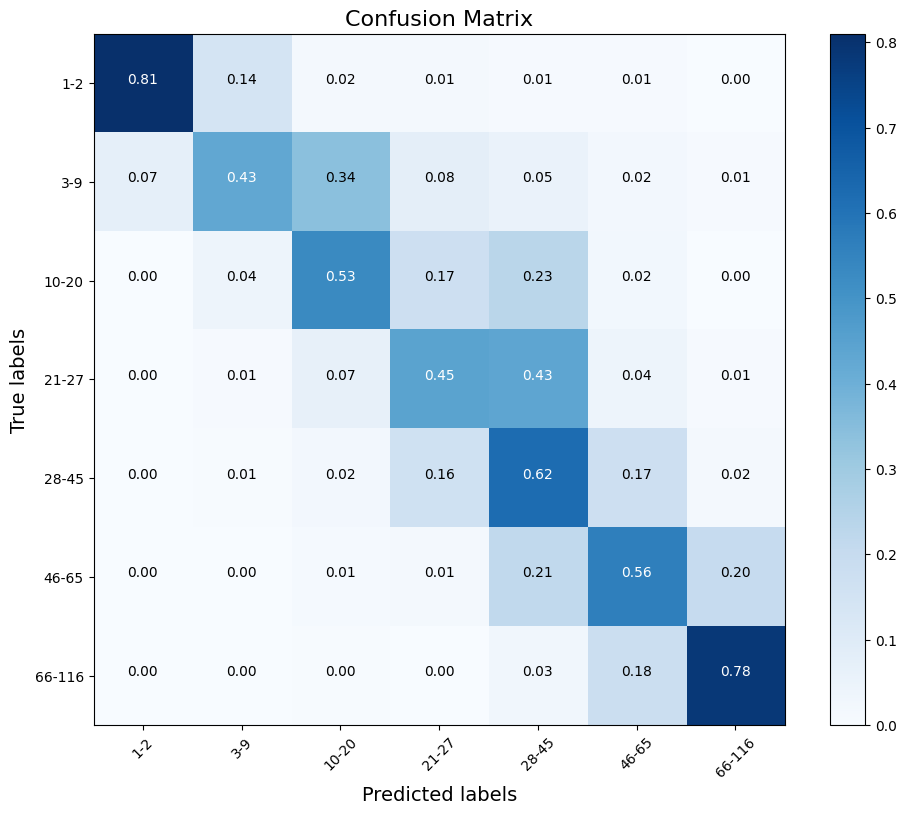

In [ ]:
import itertools

# Define your function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

# Make predictions on the validation dataset
predictions = model.predict(test_dataset)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since val_labels is one-hot encoded, convert it to class labels
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)  # Flatten the labels
true_classes = np.argmax(val_labels_np, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Age range labels
age_range_labels = [f'{start}-{end}' for start, end in age_ranges]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=age_range_labels,normalize=True, title='Confusion Matrix')
plt.show()